# The kernel two-sample test in StringPhylo

This notebook demonstrates how to perform the two-sample test in StringPhylo, using the Maximum Mean Discrepancy (MMD) as the test statistic. See Ish-Horowicz and Filippi (2002) for more details

In [1]:
import numpy as np
import pandas as pd
import os

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logging.getLogger("utils").setLevel('INFO')

# Data preparation

For the MMD calculation we will only use the ASV tables.

In [2]:
# load ASV table and phenotypes
asv_table = pd.read_csv("../data/asv_table.csv").set_index("sample_id")
logger.info(f"ASV table shape: {asv_table.shape}")
assert np.all(np.isnan(asv_table).sum()==0)

2023-01-09 19:29:26 INFO     ASV table shape: (394, 525)


# Computing string kernels

Given an $n \times p$ OTU table, the $S$ matrix is a $p \times p$ matrix of pairwise OTUs (or ASV) similarities. This is then used to compute the $n \times n$ matrix $K$ using $K = X S X^T$ (see Ish-Horowicz and Filippi, 2002).

First, we load the representative sequences from their fasta files using skbio:

In [3]:
import skbio
repr_sequences = skbio.io.read(
    "../data/ravel_refseq.fasta",
    format='fasta')
repr_sequences = [x for x in repr_sequences]
repr_sequences = [x.values.tobytes().decode("utf-8")  for x in repr_sequences]
repr_sequences = pd.Series(repr_sequences, index=asv_table.columns)
repr_sequences[0]

'AAGGGCCGTATCTCAGTCCCCTTGTGGCCGTCCACCCTCTCAGGCCGGCTACCTATCATCGCCTTGGTAAGCTCTTACCTTACCAACTAGCTAATAGGACGCAAAGCTCTCCTTTAGTGCCGTAGCTTTCATTTGCATATCATGCGATATACTAACTTATCCAGTATTATCAGAAGTTTCCCTCTGTTATCCCAGTCTAAAGGGCAAGTTCTTTACGCGTTACTCA'

Next, we compute the $S$ matrices for the kernels we want to use (a spectrum kernel with $k=9$):

In [4]:
# tell rpy2 where to find the right R packages
from rpy2.robjects.packages import importr
base = importr('base')
base._libPaths()[0] = '~/anaconda3/envs/tf2-gpu/lib/R/library'

from stringphylo.kebab_wraps import spectrum_kernel, gappy_pair_kernel, mismatch_kernel, compute_Smat

S = compute_Smat(spectrum_kernel(k=9), repr_sequences)

When we visualise this kernel we see blocks of closely-related OTUs:

Text(0.5, 1.0, 'S matrix for Spectrum kernel with k=9')

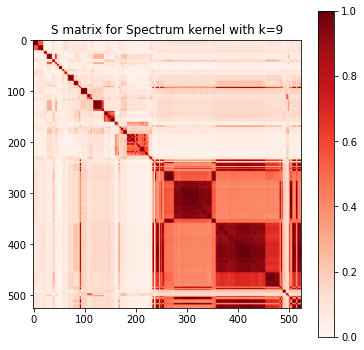

In [5]:
import matplotlib.pyplot as plt

# visualise the kernel
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(S, cmap="Reds")
plt.colorbar(im, ax=ax)
ax.set_title("S matrix for Spectrum kernel with k=9")

# Setting up the MMD calculation

We split the samples randomly into two groups and apply the CLR transform to account for compositionality. We will use the spectrum kernel with $k=9$ in this example.

In [6]:
from skbio.stats.composition import clr, closure, multiplicative_replacement

# split into two groups
rng = np.random.default_rng(1234)

# random group membersip for samples
n = asv_table.shape[0]
group_idxs = np.array_split(
    rng.permutation(n),
    2
)

# ASV counts for each group
X0 = asv_table.iloc[group_idxs[0],:].to_numpy().astype(float)
X1 = asv_table.iloc[group_idxs[1],:].to_numpy().astype(float)

# apply the CLR transform before computing the kernels
def clr_transform(x):
    return clr(closure(multiplicative_replacement(x)))

X0_clr = clr_transform(X0)
X1_clr = clr_transform(X1)

## Kernel two-sample test using spectrum and RBF kernels

The statistical significance of the test is assessed using a permutation test with 100 permutations. This is performed by the function `perm_mmd_test`, which returns the observed MMD, the MMD values in the permutation distribution and the corresponding p-value.

Pass the result of calling `string_kernel_fn_factory` with the `S` matrix we computed earlier as the `kernel_maker` argument. 

We will also compare to an RBF kernel with the median heuristic lengthscale (uses `make_rbf_kernel_fn` in place of `string_kernel_fn_factory`).

In [7]:
from stringphylo.mmd import string_kernel_fn_factory, make_rbf_kernel_fn, perm_mmd_test

#The number of permutations in the MMD significance test
n_perms = 100

# MMD two-sample test with spectrum kernel
mmd_perm_vals_string, mmd_obs_string, p_value_string = perm_mmd_test(
    X0_clr,
    X1_clr,
    kernel_maker=string_kernel_fn_factory(S, variance=1.0, forceQPD=False),
    n_perms=n_perms,
    rng=rng
)

# MMD two-sample test with RBF kernel with the median heuristic lengthscale
mmd_perm_vals_rbf, mmd_obs_rbf, p_value_rbf = perm_mmd_test(
    X0_clr,
    X1_clr,
    kernel_maker=lambda x0, x1: make_rbf_kernel_fn(x0, x1, rescale=True),
    n_perms=n_perms,
    rng=rng
)

Neither kernel rejects the null hypothesis (that the two groups from the same population). We expect this as we have split the samples at random.

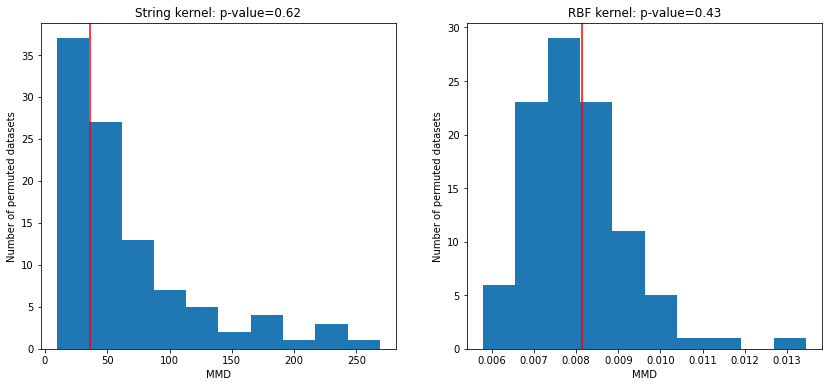

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(mmd_perm_vals_string)
axes[0].axvline(mmd_obs_string, c="red")
axes[0].set_title(f"String kernel: p-value={p_value_string:.2f}")

axes[1].hist(mmd_perm_vals_rbf)
axes[1].axvline(mmd_obs_rbf, c="red")
axes[1].set_title(f"RBF kernel: p-value={p_value_rbf:.2f}")

for ax in axes:
    ax.set_xlabel("MMD")
    ax.set_ylabel("Number of permuted datasets")